<a href="https://colab.research.google.com/github/PozzOver13/learning/blob/main/stats_and_probability/20241118_pymc_survival_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Survival
https://www.pymc.io/projects/examples/en/latest/survival_analysis/survival_analysis.html

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import pytensor

from matplotlib import pyplot as plt
from pymc.distributions.timeseries import GaussianRandomWalk
from pytensor import tensor as T

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.18.0


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
try:
    df = pd.read_csv("../data/mastectomy.csv")
except FileNotFoundError:
    df = pd.read_csv(pm.get_data("mastectomy.csv"))

df.event = df.event.astype(np.int64)
df.metastasized = (df.metastasized == "yes").astype(np.int64)
n_patients = df.shape[0]
patients = np.arange(n_patients)

In [4]:
df.head()

,time,event,metastasized
0,23,1,0
1,47,1,0
2,69,1,0
3,70,0,0
4,100,0,0


In [5]:
n_patients

44

In [6]:
df.event.mean()

0.5909090909090909

In [7]:
patients

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

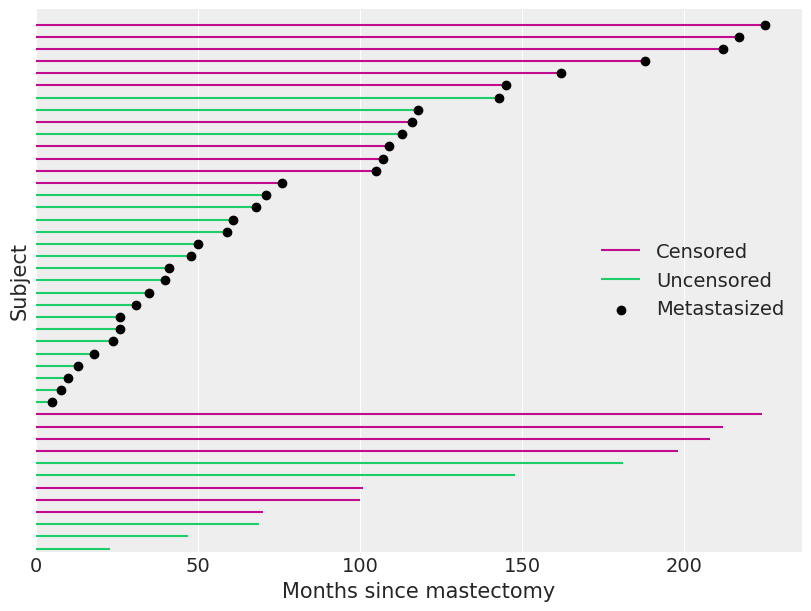

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hlines(
    patients[df.event.values == 0], 0, df[df.event.values == 0].time, color="C3", label="Censored"
)

ax.hlines(
    patients[df.event.values == 1], 0, df[df.event.values == 1].time, color="C7", label="Uncensored"
)

ax.scatter(
    df[df.metastasized.values == 1].time,
    patients[df.metastasized.values == 1],
    color="k",
    zorder=10,
    label="Metastasized",
)

ax.set_xlim(left=0)
ax.set_xlabel("Months since mastectomy")
ax.set_yticks([])
ax.set_ylabel("Subject")

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc="center right");

In [9]:
interval_length = 3
interval_bounds = np.arange(0, df.time.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

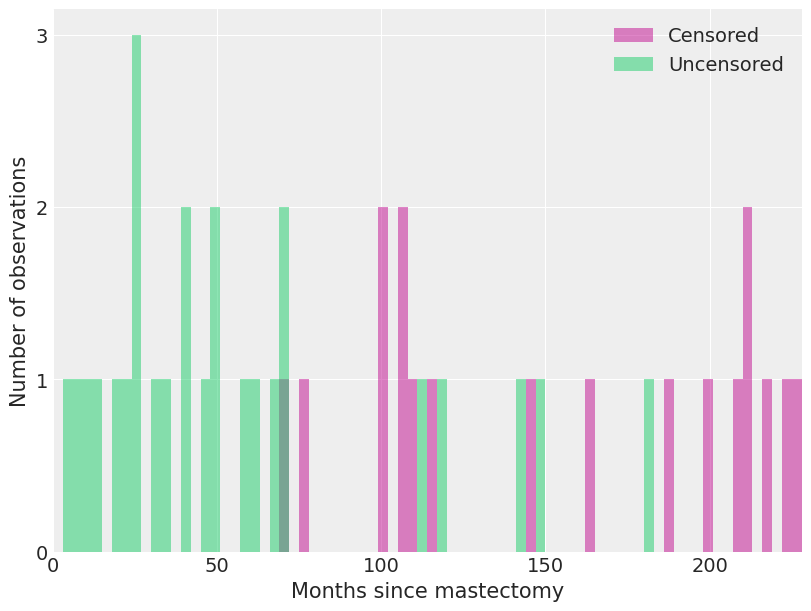

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(
    df[df.event == 0].time.values,
    bins=interval_bounds,
    lw=0,
    color="C3",
    alpha=0.5,
    label="Censored",
)

ax.hist(
    df[df.event == 1].time.values,
    bins=interval_bounds,
    lw=0,
    color="C7",
    alpha=0.5,
    label="Uncensored",
)

ax.set_xlim(0, interval_bounds[-1])
ax.set_xlabel("Months since mastectomy")

ax.set_yticks([0, 1, 2, 3])
ax.set_ylabel("Number of observations")

ax.legend();

In [11]:
last_period = np.floor((df.time - 0.01) / interval_length).astype(int)

death = np.zeros((n_patients, n_intervals))
death[patients, last_period] = df.event

In [12]:
exposure = np.greater_equal.outer(df.time.to_numpy(), interval_bounds[:-1]) * interval_length
exposure[patients, last_period] = df.time - interval_bounds[last_period]

In [13]:
coords = {"intervals": intervals}

with pm.Model(coords=coords) as model:
    lambda0 = pm.Gamma("lambda0", 0.01, 0.01, dims="intervals")

    beta = pm.Normal("beta", 0, sigma=1000)

    lambda_ = pm.Deterministic("lambda_", T.outer(T.exp(beta * df.metastasized), lambda0))
    mu = pm.Deterministic("mu", exposure * lambda_)

    obs = pm.Poisson("obs", mu, observed=death)

In [14]:
n_samples = 1000
n_tune = 1000

In [15]:
with model:
    idata = pm.sample(
        n_samples,
        tune=n_tune,
        target_accept=0.99,
        random_seed=RANDOM_SEED,
    )

Sampling chain 1, 54 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:08:16

ERROR:pymc.stats.convergence:There were 105 divergences after tuning. Increase `target_accept` or reparameterize.


In [16]:
np.exp(idata.posterior["beta"]).mean()

<xarray.DataArray 'beta' ()> Size: 8B
array(2.58639179)

<Axes: title={'center': 'beta'}>

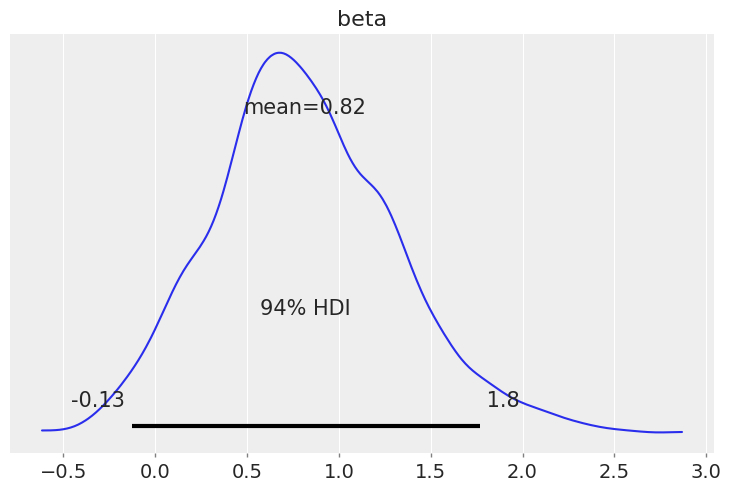

In [17]:
az.plot_posterior(idata, var_names=["beta"])

array([<Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>], dtype=object)

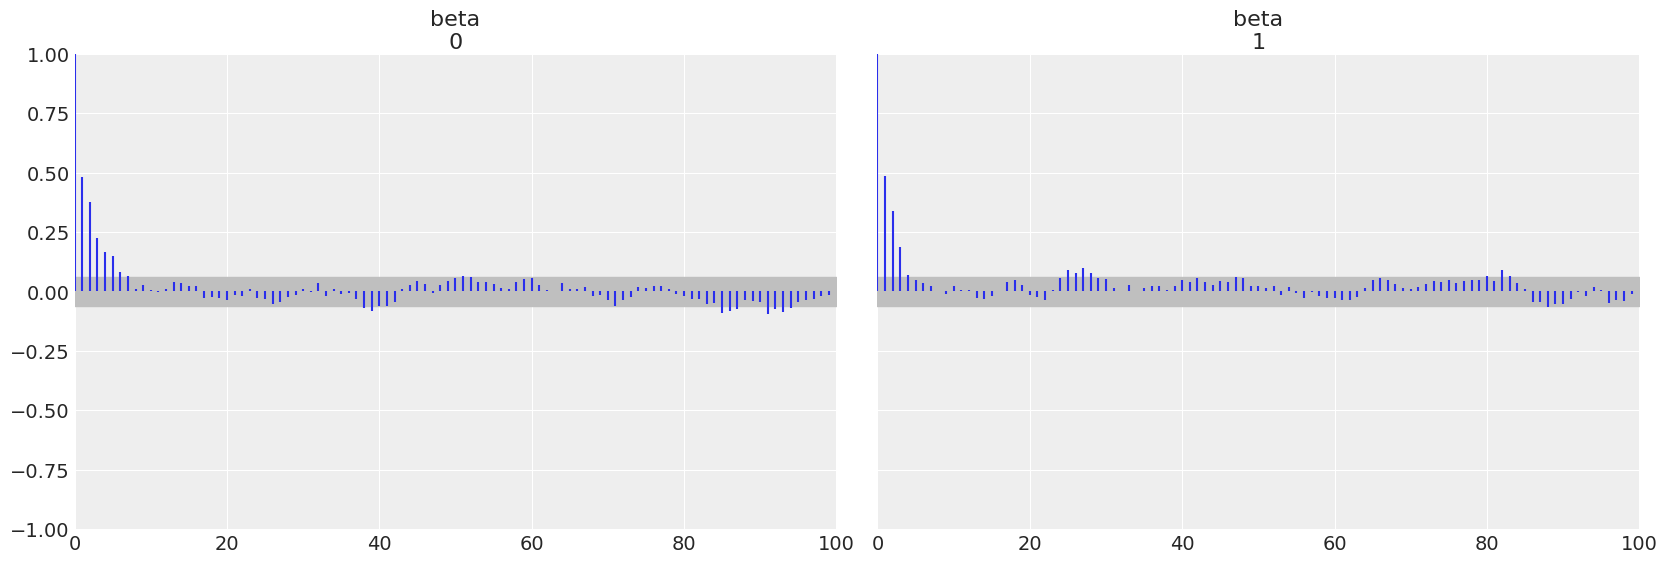

In [18]:
az.plot_autocorr(idata, var_names=["beta"])

In [19]:
base_hazard = idata.posterior["lambda0"]
met_hazard = idata.posterior["lambda0"] * np.exp(idata.posterior["beta"])

In [20]:
def cum_hazard(hazard):
    return (interval_length * hazard).cumsum(axis=-1)


def survival(hazard):
    return np.exp(-cum_hazard(hazard))


def get_mean(trace):
    return trace.mean(("chain", "draw"))

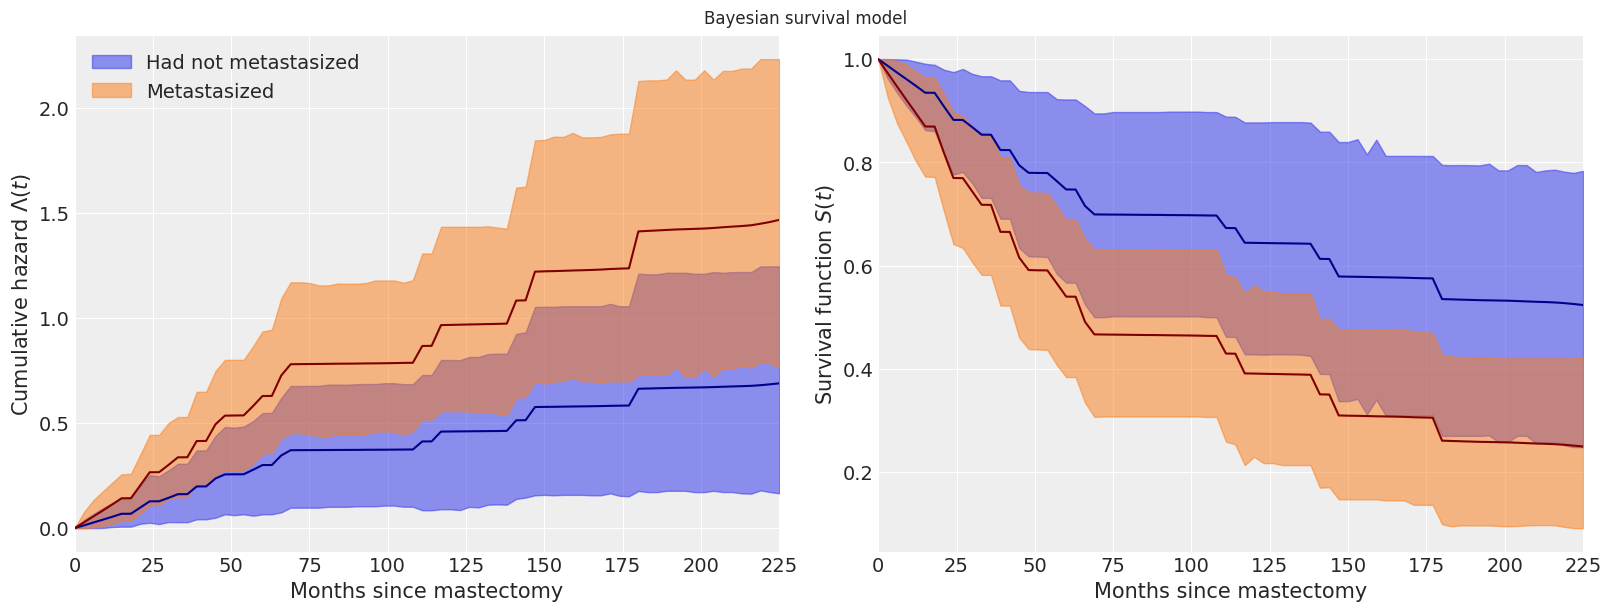

In [21]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(base_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C0",
    fill_kwargs={"label": "Had not metastasized"},
)
az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(met_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C1",
    fill_kwargs={"label": "Metastasized"},
)

hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(base_hazard)), color="darkblue")
hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(met_hazard)), color="maroon")

hazard_ax.set_xlim(0, df.time.max())
hazard_ax.set_xlabel("Months since mastectomy")
hazard_ax.set_ylabel(r"Cumulative hazard $\Lambda(t)$")
hazard_ax.legend(loc=2)

az.plot_hdi(interval_bounds[:-1], survival(base_hazard), ax=surv_ax, smooth=False, color="C0")
az.plot_hdi(interval_bounds[:-1], survival(met_hazard), ax=surv_ax, smooth=False, color="C1")

surv_ax.plot(interval_bounds[:-1], get_mean(survival(base_hazard)), color="darkblue")
surv_ax.plot(interval_bounds[:-1], get_mean(survival(met_hazard)), color="maroon")

surv_ax.set_xlim(0, df.time.max())
surv_ax.set_xlabel("Months since mastectomy")
surv_ax.set_ylabel("Survival function $S(t)$")

fig.suptitle("Bayesian survival model");

## Time varying effects


In [22]:
coords = {"intervals": intervals}

with pm.Model(coords=coords) as time_varying_model:
    lambda0 = pm.Gamma("lambda0", 0.01, 0.01, dims="intervals")
    beta = GaussianRandomWalk("beta", init_dist=pm.Normal.dist(), sigma=1.0, dims="intervals")

    lambda_ = pm.Deterministic("h", lambda0 * T.exp(T.outer(T.constant(df.metastasized), beta)))
    mu = pm.Deterministic("mu", exposure * lambda_)

    obs = pm.Poisson("obs", mu, observed=death)

In [23]:
with time_varying_model:
    time_varying_idata = pm.sample(
        n_samples,
        tune=n_tune,
        return_inferencedata=True,
        target_accept=0.99,
        random_seed=RANDOM_SEED,
    )

Sampling chain 1, 72 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:13:32

ERROR:pymc.stats.convergence:There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
az.plot_forest(time_varying_idata, var_names=["beta"]);

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

beta_eti = time_varying_idata.posterior["beta"].quantile((0.025, 0.975), dim=("chain", "draw"))
beta_eti_low = beta_eti.sel(quantile=0.025)
beta_eti_high = beta_eti.sel(quantile=0.975)

ax.fill_between(interval_bounds[:-1], beta_eti_low, beta_eti_high, color="C0", alpha=0.25)

beta_hat = time_varying_idata.posterior["beta"].mean(("chain", "draw"))

ax.step(interval_bounds[:-1], beta_hat, color="C0")

ax.scatter(
    interval_bounds[last_period[(df.event.values == 1) & (df.metastasized == 1)]],
    beta_hat.isel(intervals=last_period[(df.event.values == 1) & (df.metastasized == 1)]),
    color="C1",
    zorder=10,
    label="Died, cancer metastasized",
)

ax.scatter(
    interval_bounds[last_period[(df.event.values == 0) & (df.metastasized == 1)]],
    beta_hat.isel(intervals=last_period[(df.event.values == 0) & (df.metastasized == 1)]),
    color="C0",
    zorder=10,
    label="Censored, cancer metastasized",
)

ax.set_xlim(0, df.time.max())
ax.set_xlabel("Months since mastectomy")
ax.set_ylabel(r"$\beta_j$")
ax.legend();

In [24]:
tv_base_hazard = time_varying_idata.posterior["lambda0"]
tv_met_hazard = time_varying_idata.posterior["lambda0"] * np.exp(
    time_varying_idata.posterior["beta"]
)

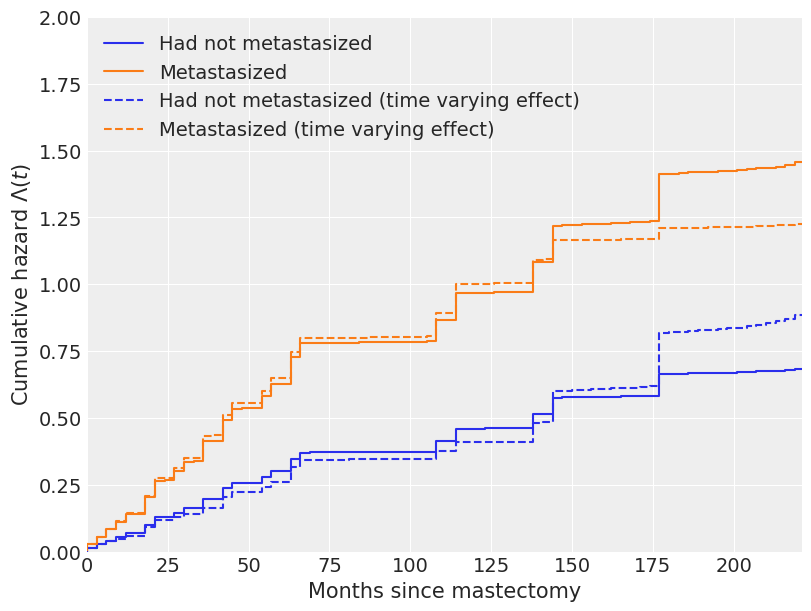

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.step(
    interval_bounds[:-1],
    cum_hazard(base_hazard.mean(("chain", "draw"))),
    color="C0",
    label="Had not metastasized",
)

ax.step(
    interval_bounds[:-1],
    cum_hazard(met_hazard.mean(("chain", "draw"))),
    color="C1",
    label="Metastasized",
)

ax.step(
    interval_bounds[:-1],
    cum_hazard(tv_base_hazard.mean(("chain", "draw"))),
    color="C0",
    linestyle="--",
    label="Had not metastasized (time varying effect)",
)

ax.step(
    interval_bounds[:-1],
    cum_hazard(tv_met_hazard.mean(dim=("chain", "draw"))),
    color="C1",
    linestyle="--",
    label="Metastasized (time varying effect)",
)

ax.set_xlim(0, df.time.max() - 4)
ax.set_xlabel("Months since mastectomy")
ax.set_ylim(0, 2)
ax.set_ylabel(r"Cumulative hazard $\Lambda(t)$")
ax.legend(loc=2);

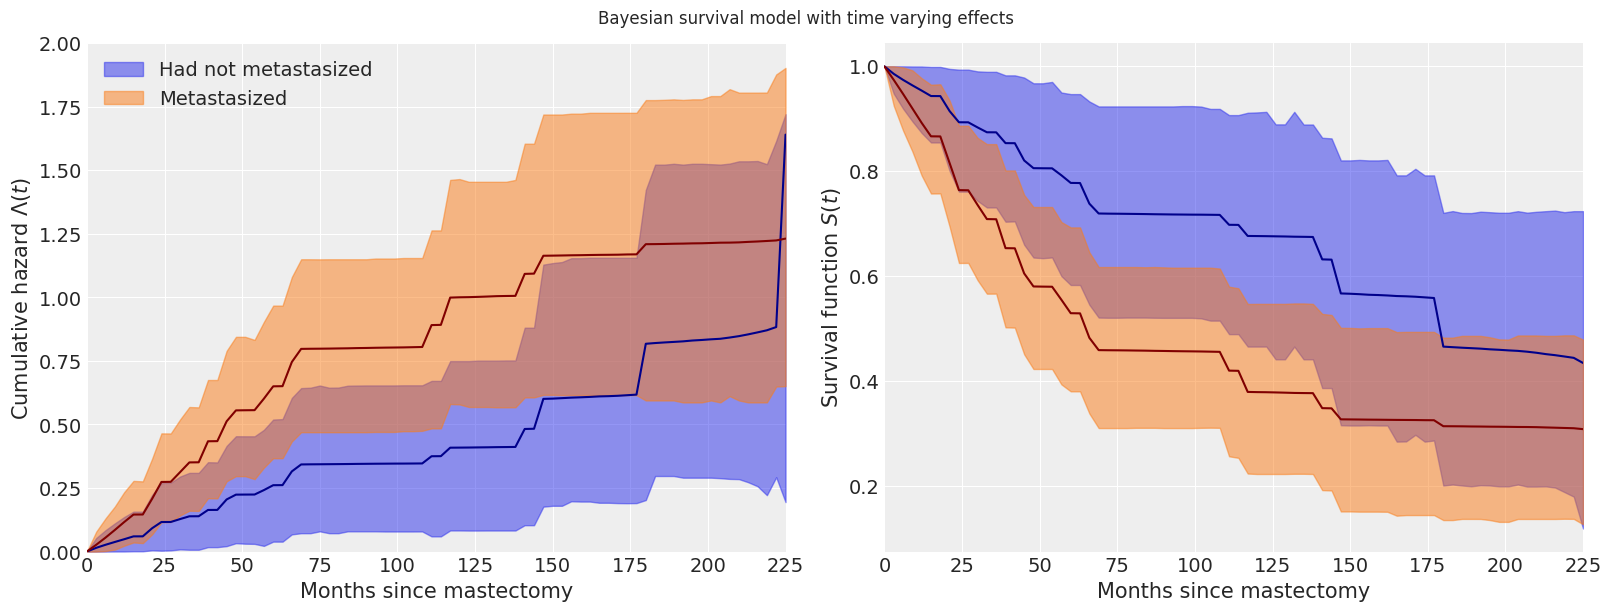

In [26]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(tv_base_hazard),
    ax=hazard_ax,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "Had not metastasized"},
)

az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(tv_met_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C1",
    fill_kwargs={"label": "Metastasized"},
)

hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(tv_base_hazard)), color="darkblue")
hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(tv_met_hazard)), color="maroon")

hazard_ax.set_xlim(0, df.time.max())
hazard_ax.set_xlabel("Months since mastectomy")
hazard_ax.set_ylim(0, 2)
hazard_ax.set_ylabel(r"Cumulative hazard $\Lambda(t)$")
hazard_ax.legend(loc=2)

az.plot_hdi(interval_bounds[:-1], survival(tv_base_hazard), ax=surv_ax, smooth=False, color="C0")
az.plot_hdi(interval_bounds[:-1], survival(tv_met_hazard), ax=surv_ax, smooth=False, color="C1")

surv_ax.plot(interval_bounds[:-1], get_mean(survival(tv_base_hazard)), color="darkblue")
surv_ax.plot(interval_bounds[:-1], get_mean(survival(tv_met_hazard)), color="maroon")

surv_ax.set_xlim(0, df.time.max())
surv_ax.set_xlabel("Months since mastectomy")
surv_ax.set_ylabel("Survival function $S(t)$")
fig.suptitle("Bayesian survival model with time varying effects");